# PREPROCESADO

### Justificacion

Despues de la carga de datos y exploracion  la mejor eleccion para mi es dividir ls etiquetas como negativas tomando los valores 1 y 2 de la rewievs y las etiquetas pisitivas de 3 en adelantes . Podria haber optado por una 3 clasificacion (connel valor 3) y haver una softmax  o incluso unir las reviewvs com puntuacion 1,2,3 para balancear un poco el dataset ya que la mayorica de las qutiquetas estan entre 4 y 5, No obstante los mejores resultados y despues de haber analizados las plabaras es la que mas seva  a ajustar a mi modelo.

En el procesado he eliminado las stopwords y todas aquelas relacionadas con la tematica que ha ser sobre tecnologia y sofware contiene muchas palabras irreleverantes para el modelo.Tambien los numeros porque mucho del sofware que se menciona en la rewiews porqeu se repiten con mucha prefiencia y  cuentan con numeracion o codigos.


In [1]:
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado


from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

In [2]:


df = pd.read_json('Software.json', lines=True)
df_limpio=pd.DataFrame(df[['overall','reviewText']])
df_limpio = df_limpio.rename(columns={'overall': 'sentiment', 'reviewText': 'review'})
df_limpio=df_limpio.sample(n = 100000)
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 350326 to 170928
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  100000 non-null  int64 
 1   review     99989 non-null   object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [3]:
#Importamos las librerias para la limpieza.
#! pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata
import string
from num2words import num2words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_limpio['review']

350326    Online version easier to use in my opinion. St...
56858     everything was as advertised and performed as ...
66675     I first purchased a Garmin Nuvi 650 GPS near t...
398730    I bought this for my daughters (2nd and 3rd gr...
324195                                    excellent product
                                ...                        
63313     I just purchased the System Mechanic and insta...
335598    Very good programs. help a lot when you are le...
188537    Well, folks, we are now seeing what happens wh...
59399     If you can figure out how to make it work; clu...
170928    I was able to use this device rather quickly a...
Name: review, Length: 100000, dtype: object

In [5]:
splitted_reviews = df_limpio['review'].str.lower().str.split()

In [6]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

In [7]:
vocabulary_ = Counter(words)

In [8]:
len(vocabulary_)

181655

# Distribucion de Rewiev por sentimientos

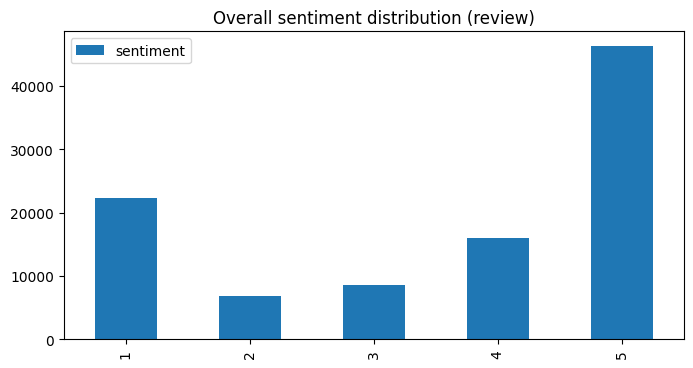

In [9]:
aux_df = pd.DataFrame(df_limpio['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [10]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [11]:
df_limpio['sentiment_label'] = df_limpio.apply(lambda row: label_sentiment(row), axis=1)

# Nube de palabras

Nube de palabras para rewievs Negativas


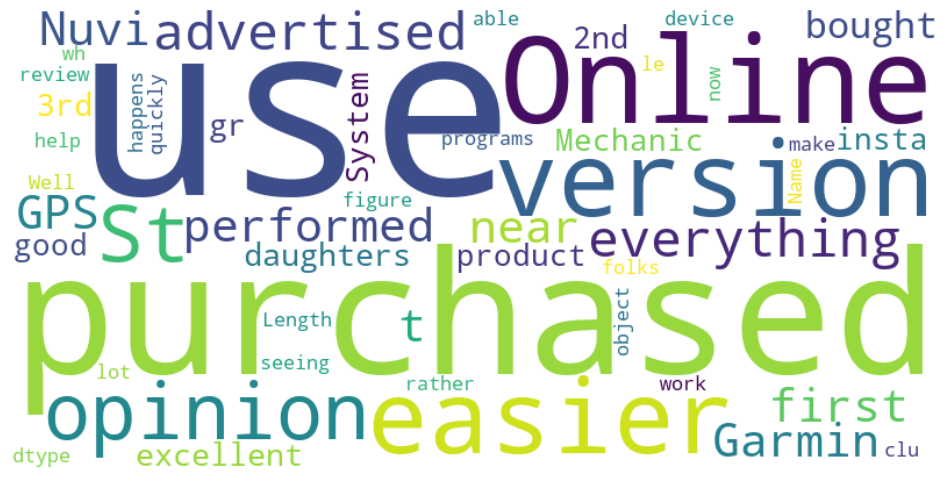

In [12]:
print("Nube de palabras para rewievs Negativas")
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear DataFrame de ejemplo
df = pd.DataFrame(df_limpio["review"])

# Crear una instancia de WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate((str(df['review'])))

# Graficar la nube de palabras
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# N-Gram

In [13]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [14]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [15]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 27314),
 (('of', 'the'), 23614),
 (('in', 'the'), 17417),
 (('it', 'is'), 16677),
 (('if', 'you'), 15322),
 (('is', 'a'), 13447),
 (('on', 'the'), 13440),
 (('i', 'was'), 13238),
 (('this', 'is'), 12835),
 (('i', 'am'), 12781)]

In [16]:
# aqui se ve claramente que tendremos que aplicar la eliminacion de las stopword

In [17]:
trigrams_freq_.most_common(10)

[(('a', 'lot', 'of'), 4255),
 (('i', 'have', 'been'), 3917),
 (('i', 'had', 'to'), 3535),
 (('this', 'is', 'a'), 3349),
 (('i', 'have', 'used'), 3348),
 (('you', 'have', 'to'), 2832),
 (('if', 'you', 'are'), 2651),
 (('easy', 'to', 'use'), 2460),
 (('have', 'been', 'using'), 2444),
 (('if', 'you', 'have'), 2417)]

# PREPROCESADO

In [18]:
sw_list = get_stop_words('es')

def limpiar_texto(texto):
    """
    Función para realizar la limpieza del texto.
    """
    
     # Convertimos textos a minusculas
    texto = unicodedata.normalize('NFKD', str(texto)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Signos de puntuacion
    texto = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in texto.split()])).strip()
    texto = re.sub(r'[' + (string.punctuation) + ']', ' ', str(texto))
    texto = ' '.join([word for word in texto.split() if word not in sw_list])
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    #eliminar numeros
    texto = re.sub('[^a-zA-Z]',' ', str(texto))
    texto= re.sub(r'[^\w\s]', ' ', texto)
    texto=  re.sub('[^\w \xC0-\xFF]',' ', str(texto))
    texto = texto.lower()
    texto = texto.strip()
    
    return texto

df_limpio['review_procesada'] = df_limpio.review.apply(limpiar_texto)

In [19]:
df_limpio.head()

,sentiment,review,sentiment_label,review_procesada
350326,4,Online version easier to use in my opinion. St...,0,online version easier to use in my still good ...
56858,4,everything was as advertised and performed as ...,0,everything was as advertised and performed as
66675,1,I first purchased a Garmin Nuvi 650 GPS near t...,1,i first purchased garmin nuvi gps near the end...
398730,5,I bought this for my daughters (2nd and 3rd gr...,0,i bought this for my daughters and they love t...
324195,5,excellent product,0,excellent product


# Eliminar STOPWORD

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords

In [22]:
lista_stopwords=pd.read_csv('lista_stopword.txt',header=None)
lista = lista_stopwords.values.flatten().tolist()
lista[1:20]

['between 2 and 6 years old',
 'Pentax K50',
 'well over 10 years',
 'Dell running Windows 10',
 'Super',
 '3400c',
 'Serif WebPlus X2',
 'Clipart',
 'NTI',
 'Adobe CS 5.5',
 'AnyTime Organizer Deluxe',
 'AVG Anti',
 'Versa Check',
 'Typing Instructor',
 'Microsoft Office 365 Home Premium 1yr Subscription',
 'Webroot Security Software',
 'Pradis',
 'the Proposal Pack Software',
 'Amazon']

In [23]:
import nltk
from nltk.corpus import stopwords
custom_stopwords = lista
nltk.download('stopwords')

custom_stopwords=lista
def remove_stopwords(text):
    # Load English stopwords and remove custom stopwords
    english_stopwords = set(stopwords.words('english')) - set(custom_stopwords)
    
    # Convert text to lowercase and split into words
    words = text.lower().split()
    
    # Filter out stopwords
    filtered_words = [word for word in words if word not in english_stopwords]
    
    # Join filtered words into a single string and return
    return ' '.join(filtered_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df_limpio['review_procesada'] = df_limpio['review_procesada'].apply(remove_stopwords)

In [25]:
print('Review original: {}'.format(df_limpio['review'].values[0]))
print('\n')
print('Review procesada: {}'.format(df_limpio['review_procesada'].values[0]))


Review original: Online version easier to use in my opinion. Still good value. 1099 misc form are back


Review procesada: online version easier use still good misc form back


In [26]:
df_limpio['review_procesada'] = df_limpio['review_procesada'].replace('', np.nan)
df_limpio = df_limpio.dropna(subset=['review_procesada'])

In [27]:
df_limpio.to_csv("df_limpio_procesado.csv")